Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Poisson}{\mathrm{Poisson}\,}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import h5py
import pystan
from scipy.stats import gamma, gaussian_kde, poisson
from scipy.special import gammaln
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Suppose we want to fit a Schechter function to galaxy luminosities:
$$
\diff{N}{L} = \frac{N}{L_* \Gamma\left( 1 - \alpha \right)} \left( \frac{L}{L_*} \right)^{-\alpha} \exp\left( -\frac{L}{L_*} \right).
$$
(Here $\alpha < 1$ so that the integral is finite even at low luminosity---this is not really a good approximation for a real g.l.f.) . Assume for the moment that we are selecting galaxies in a sufficiently narrow redshift bin that the conversion between flux and luminosity introduces no significant uncertainties (this is probably not very realistic, but whatever).  The observed luminosity is Poisson distributed about the true luminosity (i.e. we are dominated by photon counting errors), with 
$$
\beta L_\mathrm{obs} \sim \Poisson \left( \beta \frac{L}{L_*} \right), 
$$
with $\beta = 100$ so that an $L_*$ galaxy is a 10-$\sigma$ detection.  We select any galaxy with $\beta L_\mathrm{obs} > 10$ for our catalog (i.e. we impose a 3-$\sigma$ detection threshold on our catalog); this implies that our detection threshold is $\sim L_*/10$.  

We use $\alpha = 1/2$ for this example.  We fix units by choosing $L_* = 1$.  The code below draws a sample of detected galaxies.

In [3]:
alpha = 0.5
beta = 100
thresh = 10

def draw_flux(N, alpha=0.5, beta=100, thresh=10):
    assert alpha < 1, 'alpha must be < 1 or number diverges'
    
    Ltrues = gamma(1-alpha).rvs(size=N)
    
    Fobs = poisson(beta*Ltrues).rvs()
    
    selected = Fobs > thresh
    
    return Fobs[selected]

Here is a plot of the observed distribution with lots of data:

With 10000 systems, I detect 6500


/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '$p\\left( \\log L_\\mathrm{obs} \\right)$')

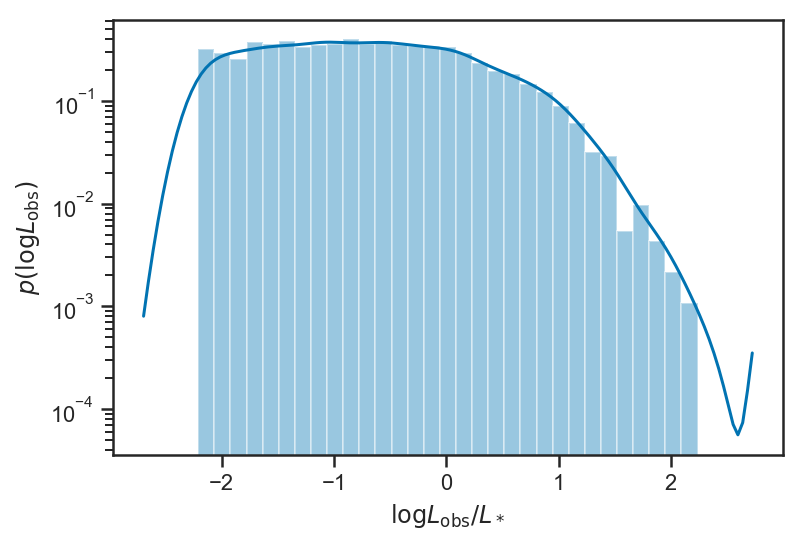

In [4]:
Fobs = draw_flux(10000, alpha=alpha, beta=beta, thresh=thresh)
Lobs = Fobs/beta
print('With 10000 systems, I detect {:d}'.format(Lobs.shape[0]))
sns.distplot(log(Lobs))
yscale('log')
xlabel(r'$\log L_\mathrm{obs} / L_*$')
ylabel(r'$p\left( \log L_\mathrm{obs} \right)$')

That's going to be too many galaxies to fit efficiently; suppose instead we have $N = 800$ systems so we detect about 400.

In [5]:
N = 800
Fobs = draw_flux(N, alpha=alpha, beta=beta, thresh=thresh)
Lobs = Fobs/float(beta)
Fobs.shape

(498,)

To estimate our selection function, we will draw an "injected" sample of true luminosities from a flat-in-log(L) distribution between $\log L/L_* = -3$ and $\log L/L_* = 3$; thus, the weight for each draw is $p(L) = L_*/(6 L)$.

Found 87404 selected injections.


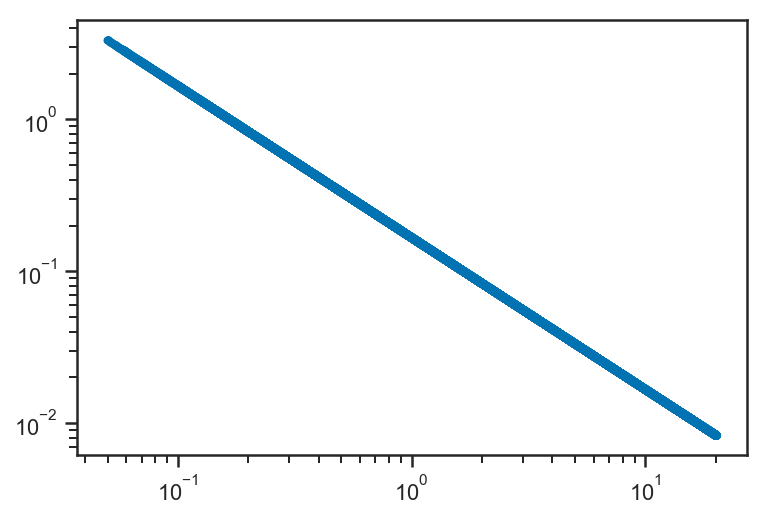

In [6]:
Ngen = 100000
Ldraw = exp(random.uniform(low=-3, high=3, size=Ngen))
F = poisson(beta*Ldraw).rvs()
sel = F > thresh
Lsel = Ldraw[sel]
wts = 1.0 / (6.0*Lsel)

print('Found {:d} selected injections.'.format(len(Lsel)))

plot(Lsel, wts, '.')
xscale('log')
yscale('log')

Now we fit, twice.  First, we use 8000 detected injections to estimate the selection effects; next we use 4000.  The two fits agree, illustrating that our marginalization over the Gaussian sampling distribution for the selection integral gives consistent results.

In [7]:
model = pystan.StanModel(file='Schechter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c3873186c452c714a06d17082f4682db NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpzkp1okg_/stanfit4anon_model_c3873186c452c714a06d17082f4682db_6766134428949885189.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [8]:
nsel = 8000
csel = random.choice(len(Lsel), size=nsel, replace=False)
data = {
    'nobs': len(Fobs),
    'nsel': nsel,
    'ngen': int(round(Ngen*(float(nsel) / len(Lsel)))),
    
    'beta': beta,
    
    'Fobs': Fobs,
    
    'Lsel': Lsel[csel],
    'wtsel': wts[csel]
}

In [9]:
fit = model.sampling(data=data)

The fit looks converged (the stats are good, too---remember to not just look at the traceplots).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29be69b0>,
      dtype=object)

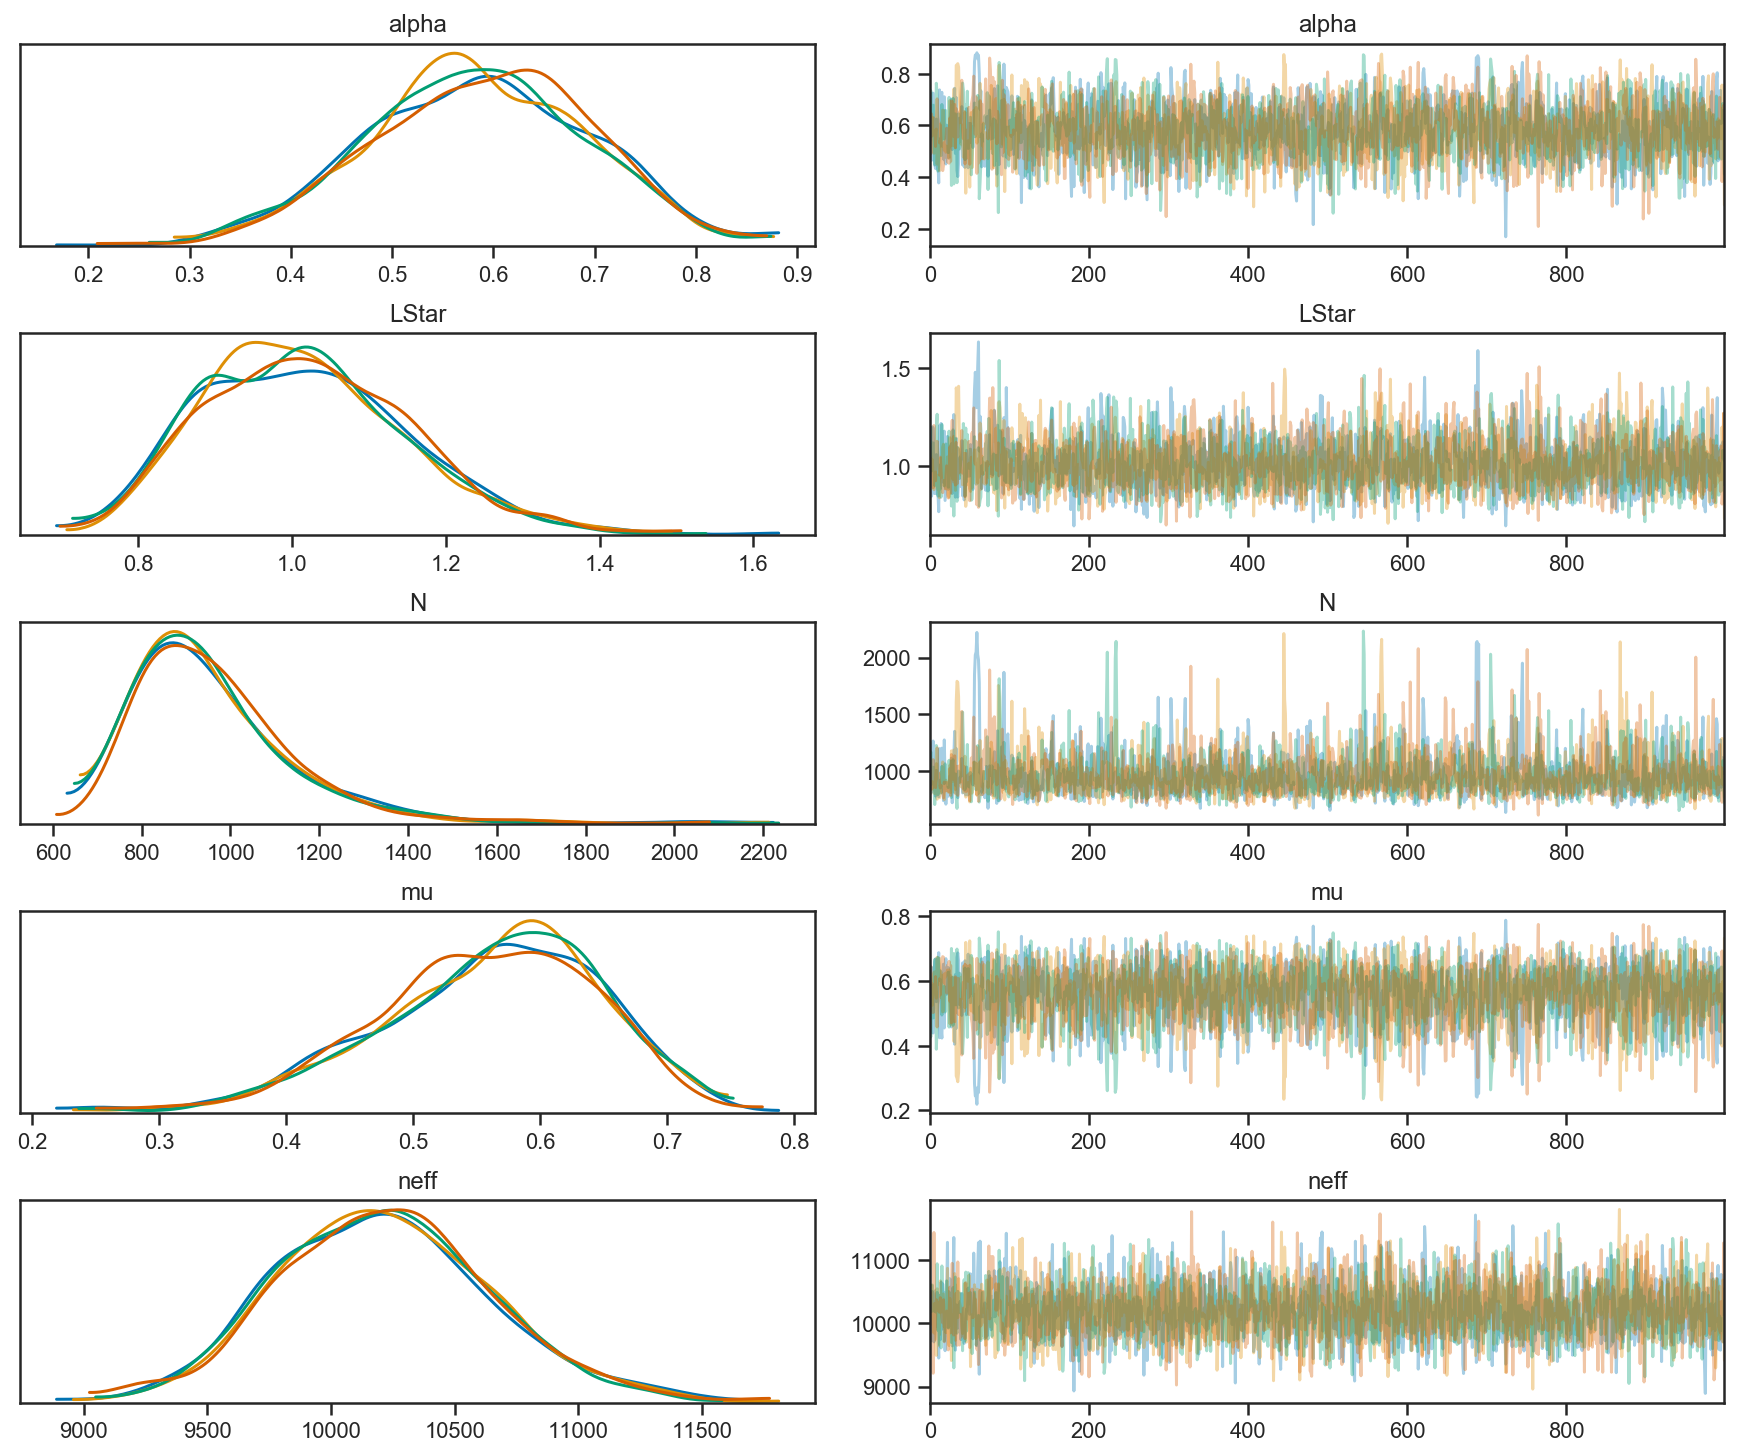

In [10]:
az.plot_trace(fit, var_names=['alpha', 'LStar', 'N', 'mu', 'neff'])

We get good inference on the power law slope, $\alpha$.

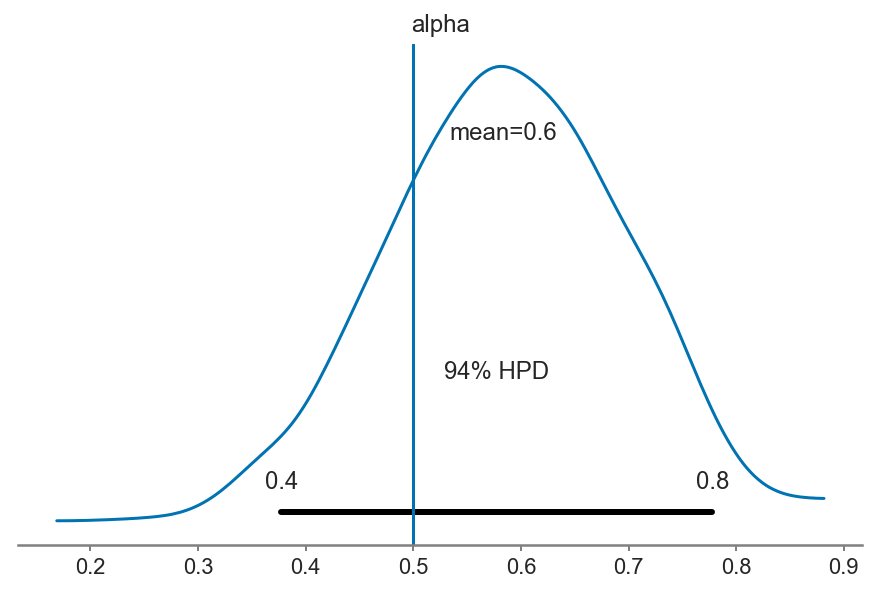

In [11]:
az.plot_posterior(fit, var_names=['alpha'])
axvline(alpha)

The fit to the turnover luminosity is pretty good, too:

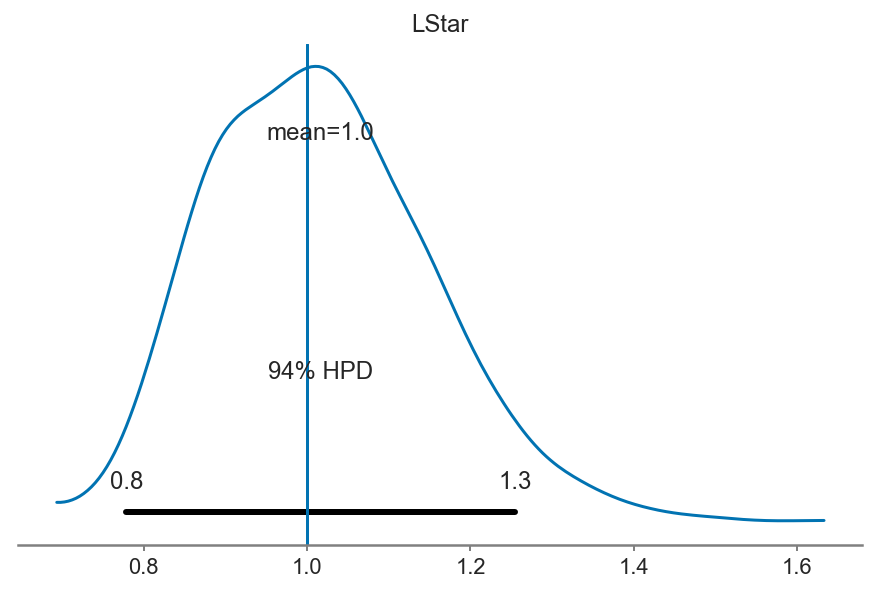

In [12]:
az.plot_posterior(fit, var_names=['LStar'])
axvline(1)

And we get a reasonable estimate of $N$ (though we permit some very-high normalizations, since we don't 

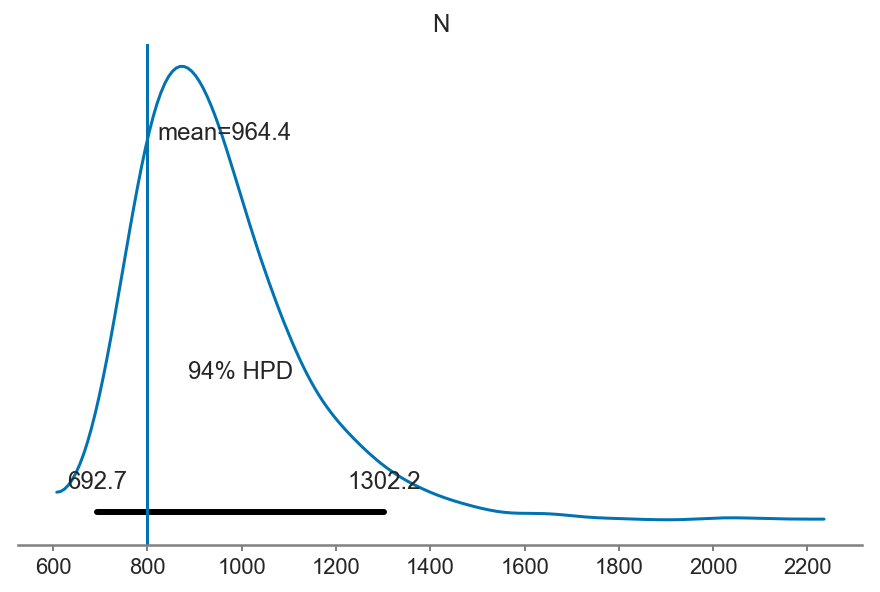

In [13]:
az.plot_posterior(fit, var_names=['N'])
axvline(N)

We should check that the effective number of samples is not too close to $4 N_\mathrm{obs}$ or else we should be worried that the analysic marginalization we have done is invalid.  The reported "safety factor" is the ratio between the 1% quantile of $N_\mathrm{eff}$ and $4 N_\mathrm{obs}$.  As we will see below, we could probably get away with a factor of two fewer samples for evaluating the selection integral; generally I recommend a safety factor of at least 2.

Safety factor (1% of N_eff / 4*nobs) = 4.6


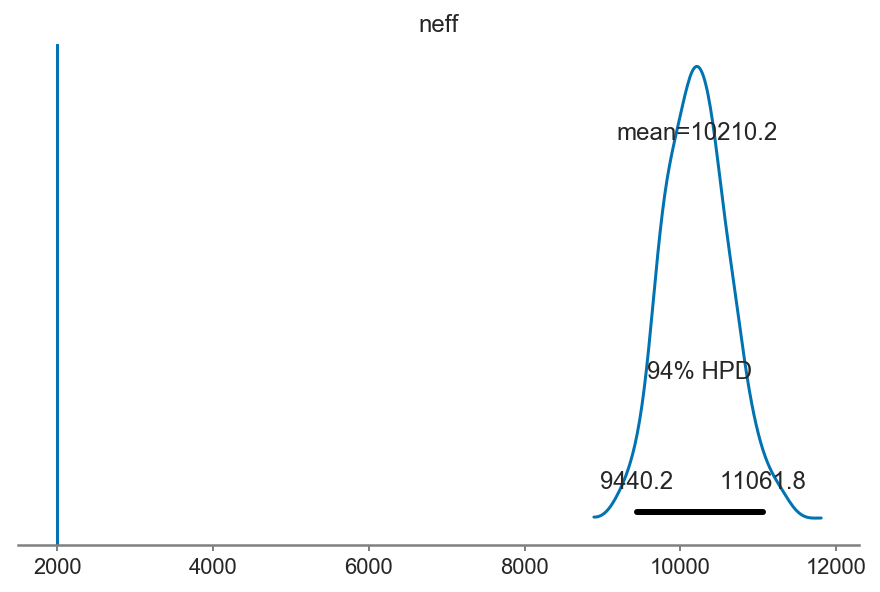

In [14]:
az.plot_posterior(fit, var_names=['neff'])
axvline(4*len(Fobs))

print('Safety factor (1% of N_eff / 4*nobs) = {:.1f}'.format(percentile(fit.extract(permuted=True)['neff'], 1)/(4*len(Fobs))))

In [15]:
nsel_small = int(round(nsel/2))
csel_small = random.choice(len(Lsel), size=nsel_small, replace=False)
data_small = {
    'nobs': len(Fobs),
    'nsel': nsel_small,
    'ngen': int(round(Ngen*(float(nsel_small) / len(Lsel)))),
    
    'beta': beta,
    
    'Fobs': Fobs,
    
    'Lsel': Lsel[csel_small],
    'wtsel': wts[csel_small]
}

In [16]:
fit_small = model.sampling(data=data_small)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a8a3ba8>,
      dtype=object)

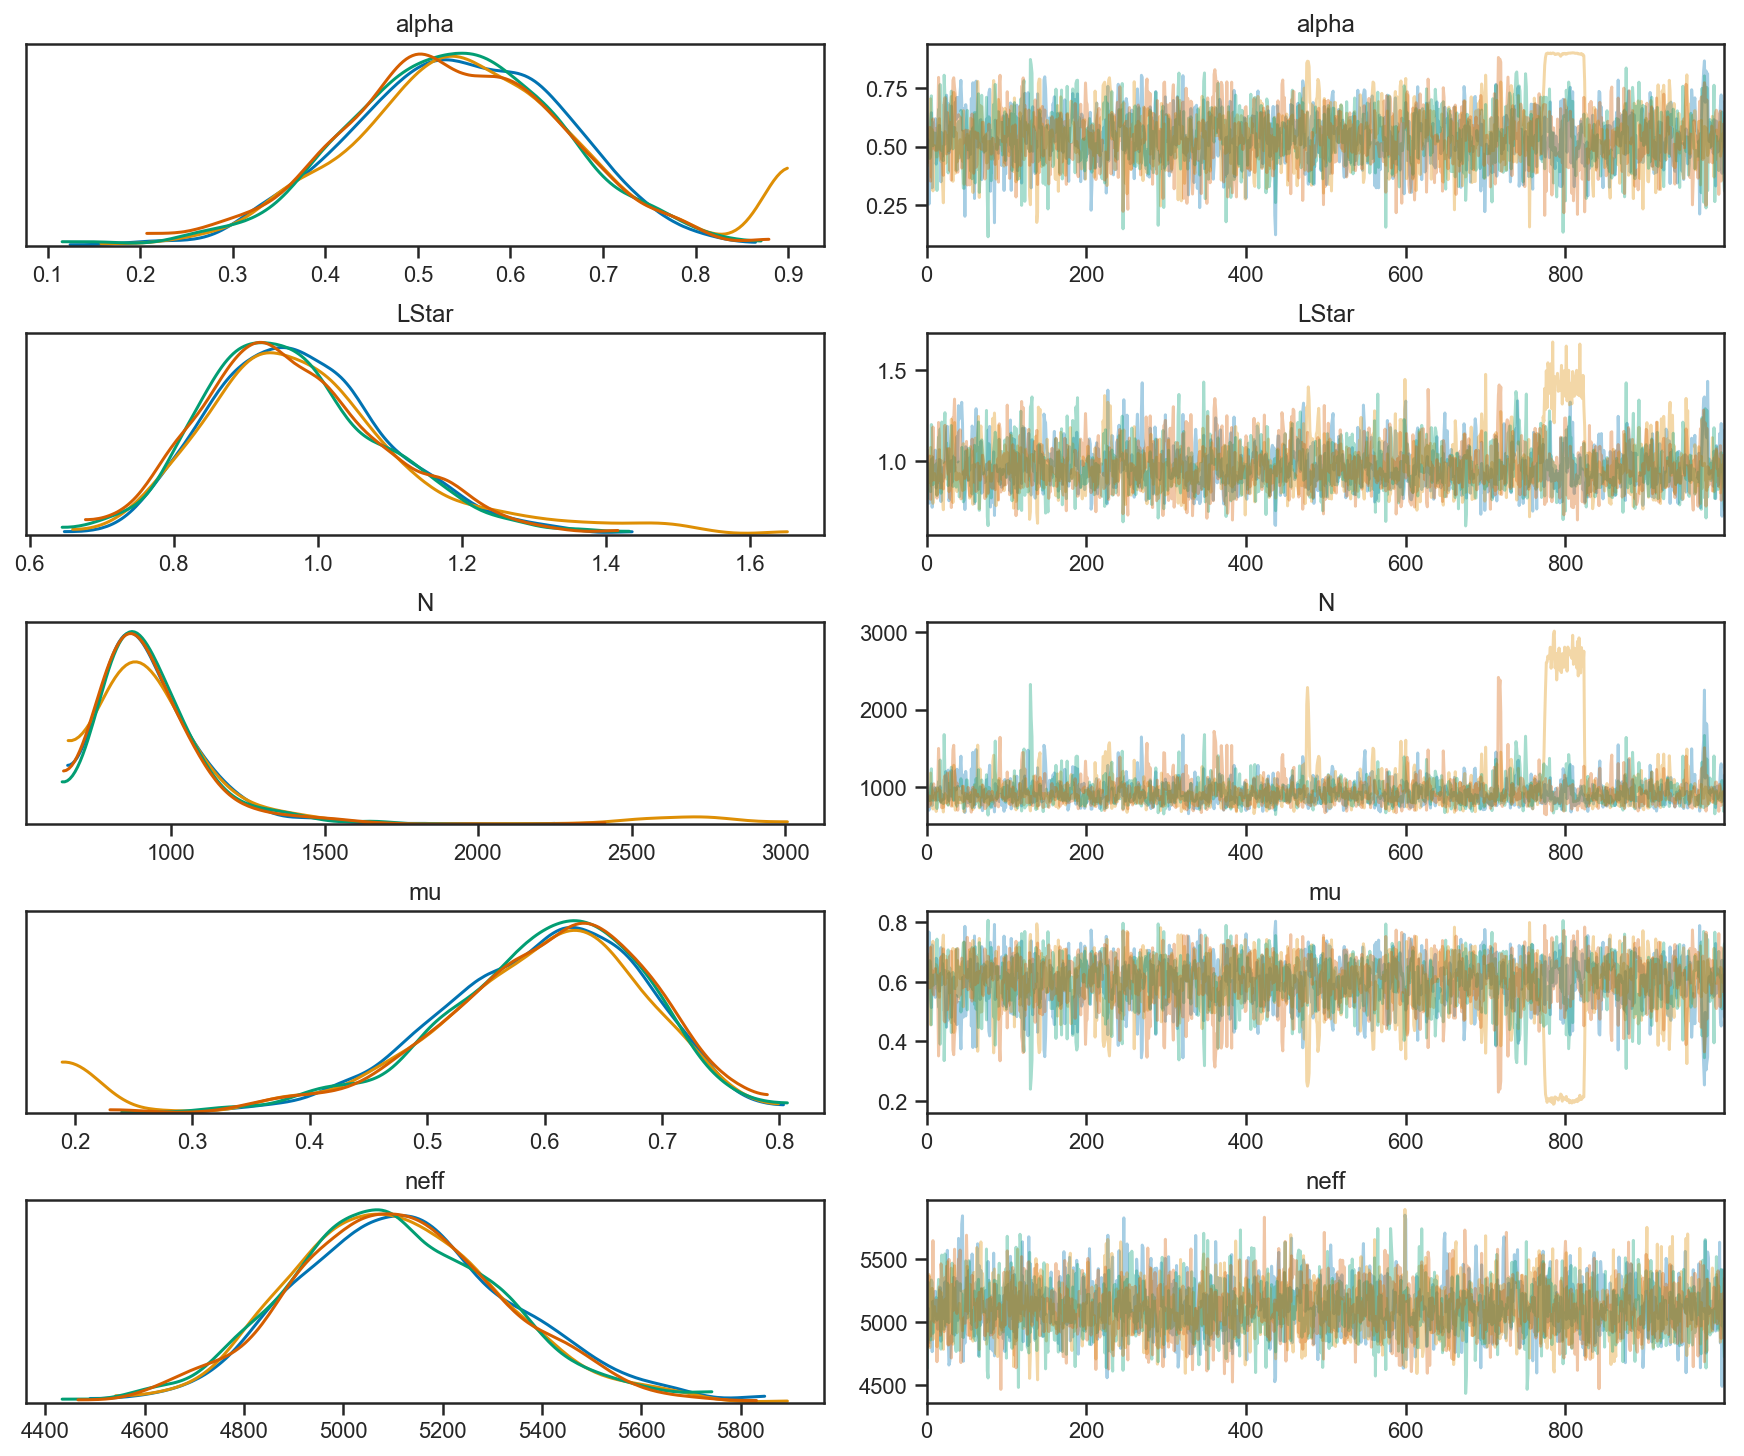

In [17]:
az.plot_trace(fit_small, var_names=['alpha', 'LStar', 'N', 'mu', 'neff'])

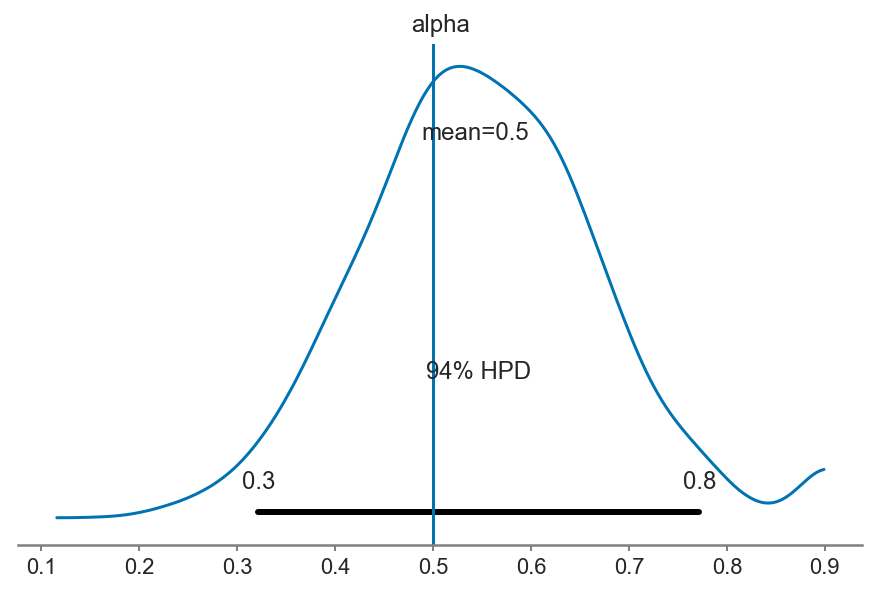

In [18]:
az.plot_posterior(fit_small, var_names=['alpha'])
axvline(alpha)

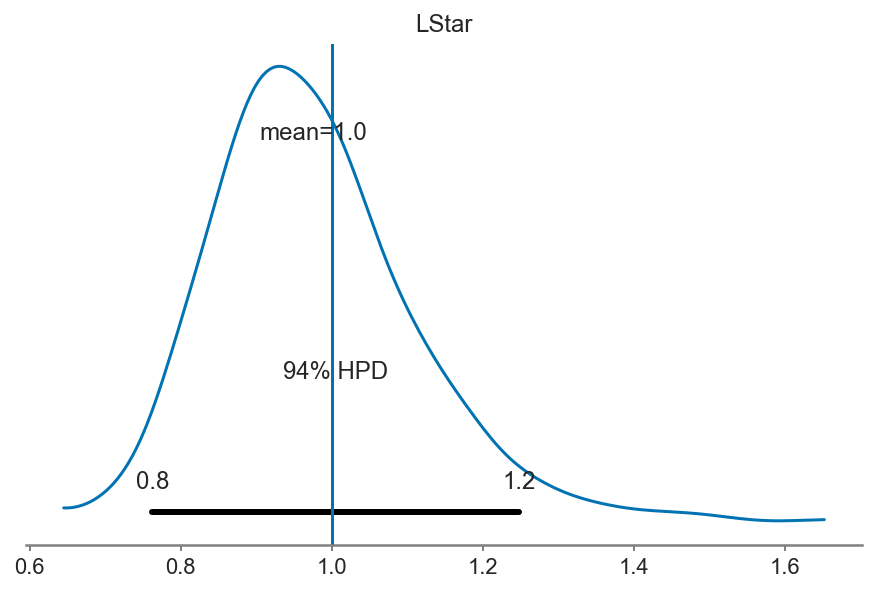

In [19]:
az.plot_posterior(fit_small, var_names=['LStar'])
axvline(1)

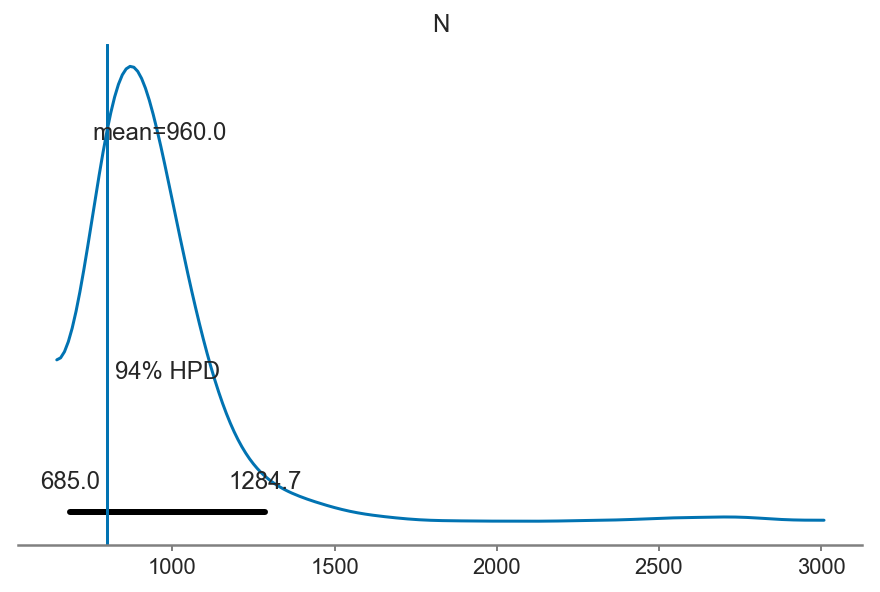

In [20]:
az.plot_posterior(fit_small, var_names=['N'])
axvline(N)

Safety factor (1% of N_eff / 4*nobs) = 2.3


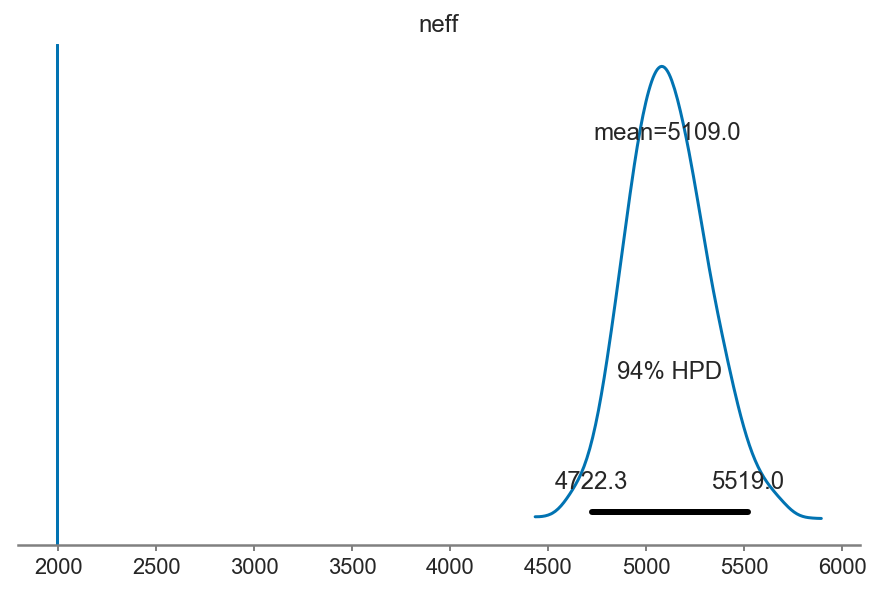

In [21]:
az.plot_posterior(fit_small, var_names=['neff'])
axvline(4*len(Fobs))

print('Safety factor (1% of N_eff / 4*nobs) = {:.1f}'.format(percentile(fit_small.extract(permuted=True)['neff'], 1)/(4*len(Fobs))))

Here we explicitly compare the chains from the two fits; they agree to well within the statistical uncertainties, indicating that the bias from the Monte-Carlo integration is under control.

In [22]:
c = fit.extract(permuted=True)
c_small = fit_small.extract(permuted=True)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


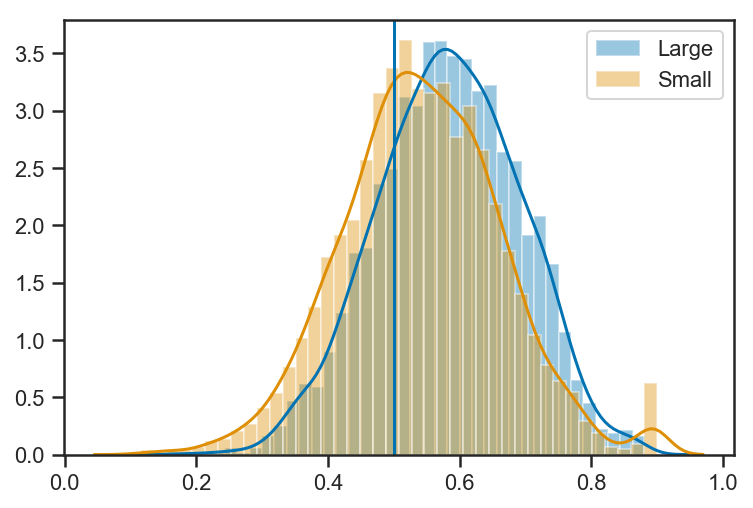

In [23]:
sns.distplot(c['alpha'], label='Large')
sns.distplot(c_small['alpha'], label='Small')
axvline(0.5)
legend(loc='best')

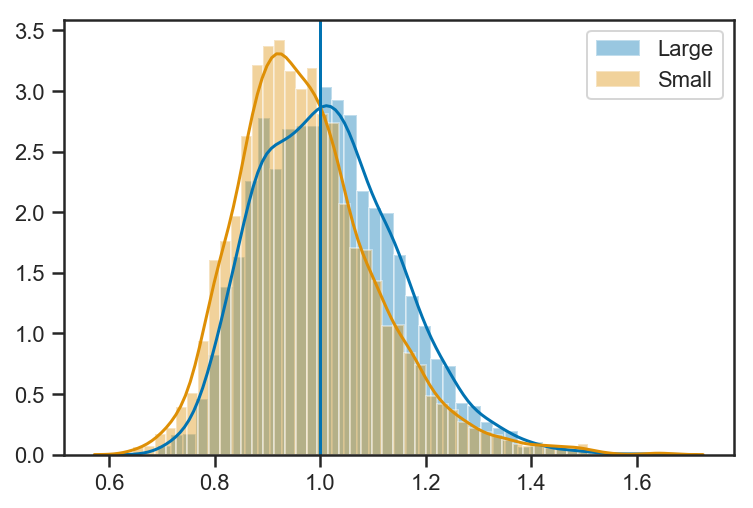

In [24]:
sns.distplot(c['LStar'], label='Large')
sns.distplot(c_small['LStar'], label='Small')
axvline(1)
legend(loc='best')

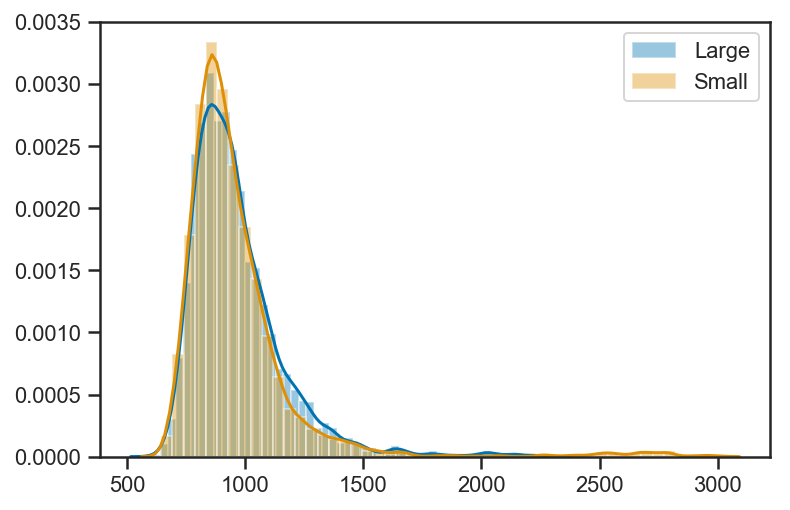

In [25]:
sns.distplot(c['N'], label='Large')
sns.distplot(c_small['N'], label='Small')
legend(loc='best')

Save both the chains for posterity:

In [26]:
with h5py.File('chains.h5', 'w') as f:
    l = f.create_group('large')
    s = f.create_group('small')
    
    for k in c.keys():
        l.create_dataset(k, data=c[k], compression='gzip', shuffle=True)
    for k in c_small.keys():
        s.create_dataset(k, data=c_small[k], compression='gzip', shuffle=True)